In [13]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm

In [14]:
def gen_sample(n, mus, sigmas):
    return np.array([mus + stats.norm.rvs(size = n, loc = 0, scale = sigmas[i]) for i in np.arange(len(sigmas)) ])

def gen_mus_sigma(nb_stateux, nb_samples):
    return (stats.uniform.rvs(size=nb_samples, loc=0, scale=200), stats.uniform.rvs(size=nb_stateux, loc=0, scale=40))

nb_stateux = 7
sample_length = 10

(mus, sigma) = gen_mus_sigma(nb_stateux, sample_length)
sample = gen_sample(sample_length, mus, sigma)
print len(sample), len(sample[0])
print mus
print sigma
print sample
print [np.mean([sample[i, j] for i in np.arange(len(sigma))]) for j in np.arange(len(mus))]

print sample.shape

7 10
[  33.18665468  107.6714999   165.70823926   45.91772282   23.85264823
  111.46990608  192.66993673   46.52193126   40.36959864   78.02887413]
[ 27.15365214  33.08889563  11.21643385   4.30160891  33.73399379
  19.38764191  25.41023455]
[[  33.79954001  118.65646461  149.21589051   56.35335079   11.71026533
   109.60452222  144.47922079   49.93802559   73.06424316   37.18545001]
 [  -4.57693351   69.38617975  178.50971704   72.21993126   13.73017249
   120.39925372  161.19145977   53.18443391   63.55535052   84.90966057]
 [  50.52889226  101.2898307   179.59706174   48.51047357   38.24064055
   125.11776993  191.50573783   24.60827031   42.02147987   89.47811601]
 [  26.54283682  108.88403538  166.70792343   50.2557637    25.0537119
   106.8688892   195.76063956   41.77031989   36.60886354   79.44403611]
 [  -5.41334722  178.53949772  150.46087935   66.77463104   30.28246304
   189.23597537  229.58859624   55.356656     75.25808063   90.78231487]
 [  24.81450201  135.21234442  160

In [37]:
import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(5000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]

 [-----------------100%-----------------] 5000 of 5000 complete in 6.7 sec

In [38]:
%history -f 7stateux_model.py -l 1

File u'7stateux_model.py' exists. Overwrite? y
Overwriting file.


27.1423201521
106.07288476
158.393122088
48.4553956704
25.7887160804
109.30524094
181.352956051
41.1818417381
40.6739849823
70.6414409048


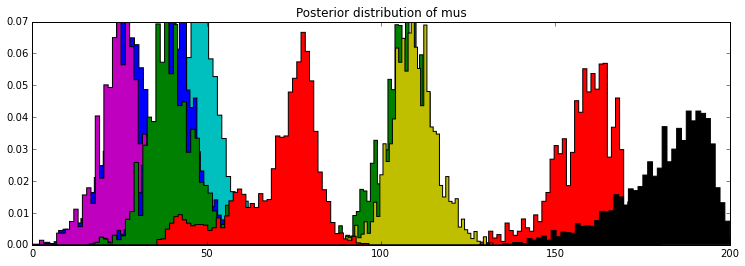

In [39]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean())

25.0794574227
26.8407936149
19.1330841516
10.2958656167
48.1857532099
21.4046408288
26.8095902773


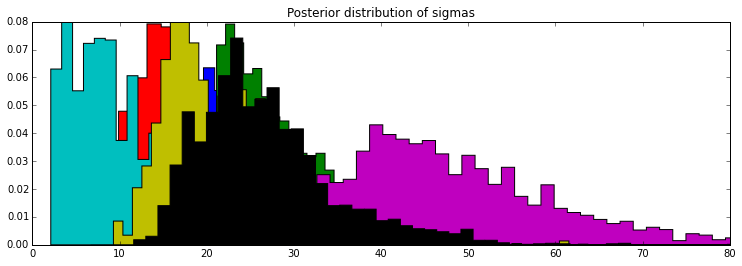

In [41]:
figsize(12.5, 4)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,80))
    print (sigma_traces[i].mean())

In [42]:
# Now going parallel

from IPython.parallel import Client
client = Client()

direct         = client[:]
direct.block   = True
print (direct)

def checkhostname():
    import socket
    return socket.gethostname()

direct.apply(checkhostname)

import numpy as np
with direct.sync_imports():
    import pymc as pm
    import numpy as np

<DirectView [0, 1, 2, 3,...]>
importing pymc on engine(s)
importing numpy on engine(s)


In [43]:
export_dict = {k: globals()[k] for k in ('sample', 'nb_stateux')}
direct.push(export_dict, block=True)

model_script = open('7stateux_model.py').read()
print model_script

import numpy as np

(nb_stateux, sample_length) = sample.shape

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(5000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]



In [44]:
direct.execute(model_script)

<AsyncResult: finished>

In [45]:
def get_trace(var_name):
    all_traces = direct.pull(var_name)
    a = len(all_traces)
    b = len(all_traces[0])

    y = [np.array([all_traces[i][j] for i in range(a)]).flatten() for j in range(b)]
    
    return y

mu_traces = get_trace("mu_traces")
sigma_traces = get_trace("sigma_traces")

print mu_traces
print len(mu_traces), len(mu_traces[0])

[array([ 29.35785642,  29.35785642,  29.35785642, ...,  29.5929604 ,
        29.5929604 ,  29.5929604 ]), array([ 101.70606662,  101.70606662,  101.70606662, ...,  107.51475243,
        112.93366784,  112.93366784]), array([ 162.12605841,  162.12605841,  162.12605841, ...,  160.67880571,
        160.67880571,  160.67880571]), array([ 53.4113382 ,  49.18130671,  50.868366  , ...,  47.16540145,
        47.16540145,  47.16540145]), array([ 27.37575068,  27.37575068,  26.07384054, ...,  26.8883073 ,
        26.8883073 ,  26.8883073 ]), array([ 110.82033067,  110.82033067,  108.04654243, ...,  110.91580921,
        110.91580921,  110.91580921]), array([ 181.84229909,  181.84229909,  181.84229909, ...,  189.05414127,
        189.05414127,  189.05414127]), array([ 45.66253389,  45.66253389,  45.66253389, ...,  41.11714163,
        41.11714163,  39.12902868]), array([ 38.95355609,  34.73570043,  41.95620975, ...,  37.12559844,
        37.12559844,  37.12559844]), array([ 66.77947811,  66.77947

27.6432786727 33.1866546846
106.285913302 107.671499903
160.2032287 165.708239265
48.5274360656 45.9177228192
26.2488377555 23.852648229
109.74822488 111.469906079
184.167590171 192.669936726
40.596840219 46.5219312565
39.6676677248 40.3695986426
74.9152507085 78.02887413


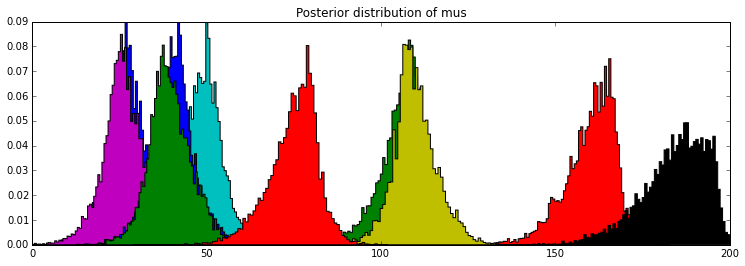

In [46]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=100, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean()), mus[i]

(26.18751111641464, 24.910986992197564, 27.153652135593855)
(26.858692762693021, 25.493330912037987, 33.088895625542889)
(17.299955427100617, 16.163507060747854, 11.216433851705997)
(8.6072779050784707, 7.7717800178542582, 4.3016089120579259)
(47.910176532911485, 45.503172298037491, 33.733993786166032)
(20.622446585467017, 19.404818234924981, 19.387641909228257)
(26.340527800173234, 24.886250902392071, 25.410234548713539)


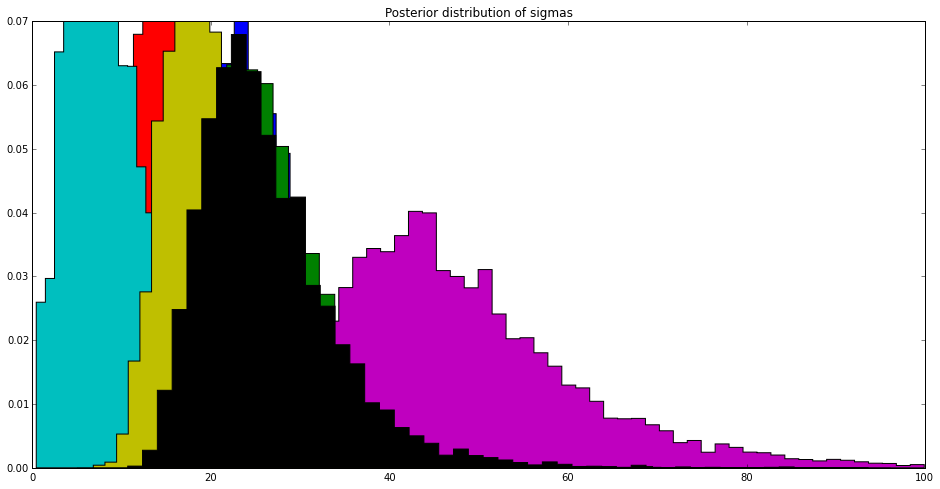

In [48]:
figsize(16, 8)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,100))
    print (sigma_traces[i].mean(), np.median(sigma_traces[i]), sigma[i])